In [37]:
import pandas as pd
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics

from transformers import AutoTokenizer, AutoModel

# Загрузка и просмотр данных

### Загружаем трейн-датасет и смотрим на данные

In [2]:
url_train = 'D:\All_Projects\Programm_Projects\Projects\Cism-NLP\data\data_train.csv'
dfComments_train = pd.read_csv(url_train, sep=',', engine='python')
dfComments_train.head(12)

,Unnamed: 0,comment,toxic
0,3795,дегенератов везде хватает. Маркировать бы их к...,1.0
1,4640,Почему я не видел в продаже орочьих кружек? Ох...,0.0
2,7932,Напоминает новую машину в минимальной комплект...,0.0
3,4184,не узнать его ебанутый говор - это ещё уметь н...,1.0
4,1366,Я более субъективно оцениваю и на собственном ...,0.0
5,2246,"Ну рентабельность зависит, сколько за это гото...",0.0
6,3226,"Шшшшшш, тш тш тш тшшшш, спокойно, всё хорошо, ...",1.0
7,9949,А сколько платит государство? Вот это прям оче...,0.0
8,1383,Magic Fly - заглавная композиция с дебютного а...,0.0
9,470,"Обивку лучше химчистка, душевую кабину силит б...",1.0


### Загружаем тест-датасет и смотрим на данные

In [3]:
url_test = 'D:\All_Projects\Programm_Projects\Projects\Cism-NLP\data\data_test_public.csv'
dfComments_test = pd.read_csv(url_test, sep=',', engine='python')
dfComments_test.head(12)

,Unnamed: 0,comment,toxic
0,14051,"Весь мир знает, что свиньи это русские. Это ва...",1.0
1,13291,"Речь не о том, что ютуб подсовывает, а о самых...",0.0
2,10641,"А если аллергия, ещё и звуковые спецэффекты бу...",0.0
3,8855,где купить такую красоту?\n,0.0
4,1948,Почему ты такой тупой ? я ж объяснил на что ко...,1.0
5,3129,"Какая должна быть адекватная зарплата, чтобы я...",0.0
6,7101,Если есть оборудование - да. Там был вопрос в ...,0.0
7,11322,"Как я понял, строительство стадиона было в т.ч...",0.0
8,8799,А смысл? Сторонники Н все равно ведь ни одному...,0.0
9,5456,"Вопрос не в размере, а в наличии вообще и в во...",0.0


### Далее посмотрим на распределение классов в тест и трейн выборках

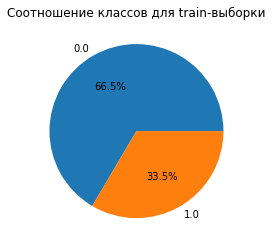

In [4]:
dfComments_train['toxic'].value_counts().plot(kind='pie', title='Соотношение классов для train-выборки', autopct='%1.1f%%')
plt.axis('off')
plt.show()

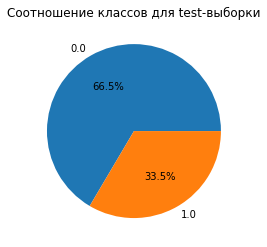

In [5]:
dfComments_test['toxic'].value_counts().plot(kind='pie', title='Соотношение классов для test-выборки', autopct='%1.1f%%')
plt.axis('off')
plt.show()

Как можно видеть, классы не сбалансорованы. А это значит, что метрика ` accuracy ` нам не подходит. 

Для оценки моделей, будем использовать метрики `f1-score` и ` ROC-AUC` , хорошо описывающие модели для бинарной классификации с несбалансированнми классами

In [26]:
sentences_train = list(dfComments_train.comment.values)
labels_train = dfComments_train.toxic.astype(int).values

sentences_test = list(dfComments_test.comment.values)
labels_test = dfComments_test.toxic.astype(int).values

# Формирование эмбедингов коментариев

## Формирование embeddings_train

LaBSE - модель, хорошо показавшая качество своих эмбедингов на 6 из 10 бенчмарков (см. https://habr.com/ru/post/562064/)  
"Легковесность модели" был один из важнейших параметров, для возможности проведения большего количества экспериментов, в условиях слабого железа. Для решения задачи, я взял модель LaBSE, но значительно облегченную, т.к в ее словаре остались только русские и английские токены  

ссылка на предобученную модель: https://huggingface.co/cointegrated/LaBSE-en-ru

In [7]:
# model_url = 'rubert-toxic-pikabu-2ch'
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


max_length = 64  
truncation=True - усечение до max_length  

https://huggingface.co/transformers/v3.0.2/preprocessing.html

Сокращаем наши батчи до максимального размера 64, и дозаполняем нулями те батчи, которые имеют меньший размер

In [8]:
encoded_input_train = tokenizer(sentences_train, truncation=True, padding=True, max_length=64, add_special_tokens=True, return_tensors='pt')

Формируем эмбединги для всех элементов тензора ` encoded_input_train ` 

In [9]:
with torch.no_grad():
    model_output = model(**encoded_input_train)

In [10]:
embeddings = model_output.pooler_output

In [11]:
embeddings_train = torch.nn.functional.normalize(embeddings)

## Формирование embeddings_test

Выполняем все те-же шаги, что и для трейн-эмбедингов

In [13]:
encoded_input_test = tokenizer(sentences_test, truncation=True, padding=True, max_length=64, add_special_tokens=True, return_tensors='pt')

In [14]:
with torch.no_grad():
    model_output = model(**encoded_input_test)

In [15]:
embeddings = model_output.pooler_output

In [16]:
embeddings_test = torch.nn.functional.normalize(embeddings)

## Fit LogisticRegression

In [38]:
lr_clf = LinearSVC()
lr_clf.fit(embeddings_train, labels_train)
# unmasker.fit(train_features, labels_train)

LinearSVC()

## Сохраняем модель

In [39]:
filename = 'LogisticRegression_model.sav'
pickle.dump(lr_clf, open(filename, 'wb'))

# Итоговый скор

In [20]:
f1 = metrics.f1_score(labels_test, lr_clf.predict(embeddings_test))
print(f1)

0.8556034482758621


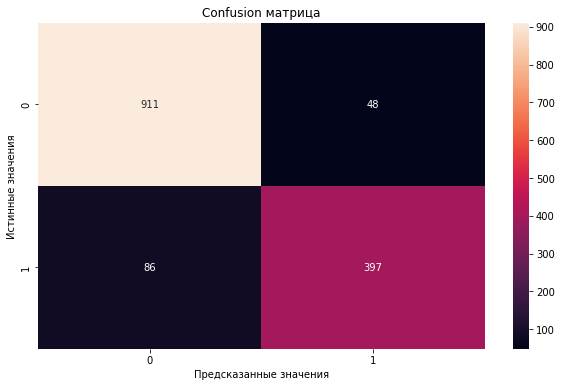

In [21]:
cm = metrics.confusion_matrix(labels_test, lr_clf.predict(embeddings_test))

def plotConfusionMatrix(cm):
    """
    Функция для отрисовки "тепловой карты" confusion матрицы.
    
    """
    fig = plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion матрица')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    
    return None

plotConfusionMatrix(cm)

In [22]:
def plotROC(y_test, probs, titl=''):

    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(titl)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TP')
    plt.xlabel('FP')
    plt.show()
    return None

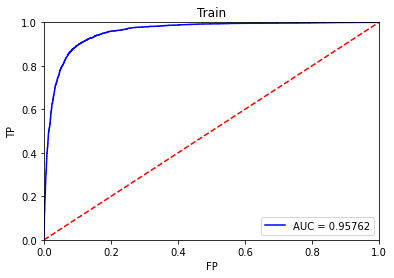

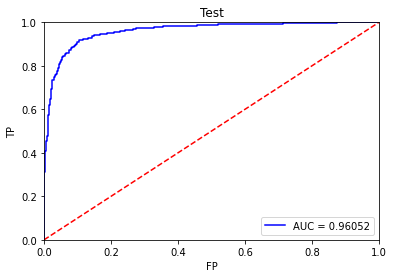

In [23]:
probs = lr_clf.predict_proba(embeddings_train)[:,1]
plotROC(labels_train, probs, 'Train')

probs = lr_clf.predict_proba(embeddings_test)[:,1]
plotROC(labels_test, probs, 'Test')

## Скоры других моделей

classifier_pipeline = Pipeline(  
            ("vectorizer", TfidfVectorizer()),  
            ("classifier", LinearSVC())/LogisticRegression() 
        )

In [24]:
pd.DataFrame([0.824444, 0.801743], index=['TF-idf + LinearSVC', 'TF-idf + LogisticRegression'], columns=['f1 score'])

,f1 score
TF-idf + LinearSVC,0.824444
TF-idf + LogisticRegression,0.801743


In [25]:
pd.DataFrame([0.93899, 0.89466], index=['TF-idf + LinearSVC', 'TF-idf + LogisticRegression'], columns=['ROC-AUC'])

,ROC-AUC
TF-idf + LinearSVC,0.93899
TF-idf + LogisticRegression,0.89466


# Итоги и идеи по улучшению пайплайна

## Итоги

f1: 0.8556034482758621  
ROC-AUC: 0.96052  

Получившаяся модель неплохо справляется с задачей, и за счет классификации сообщейни логистической регрессией, занимает не так много памяти, сколько заняли бы нейросетевые BERT-решения. В случаях жесткого ограничения в вычислительных ресурсах, зместо Bert-ембеддингов можно использовать Tf-Idf векторизацию, с потерей f1-скора ~0.03

Модель 'ruBert − Toxic' из статьи https://habr.com/ru/company/vk/blog/526268/ показывает f1-score, на ~0.06 выше, что является хорошим приростом в качестве. И для решения реальных задач, при отсутствии жестких ограничений по мощности, лучше использовать эту модель, предобученную на целевом датасете.  

## Идеи по улучшению пайплайна

Учитывая специфику задачи, жесткая предобработка текста может "упустить", интересные закономерности в используемых оскорбительных эпитетах. Удаление стоп-слов может нарушить некоторые устоявшиеся оскорбительные выражения.  
Мною было проведено не достаточно исследований, для обоснования этого тезиса, но исследовательская "интуиция" говорит именно это. Был бы рад получить обратную связь по этому вопросу.  

Поверхностная предобработка данных с удалением стоп-слов и ссылок ,и последующим стеммингом, показала уменьшение f1-скора.  
Учитывая, что в датасетах, есть экземпляры представленные в виде: "URL-ссылка" - "label". Отказ от пребобработки текста, мне кажется обоснованным.

Также, для увеличения качества модели, необходимо сформировать более качественный датасет. Начиная от решения проблемы представления "URL-ссылка" - "label", названной выше, заканчивая попыткой учета контекста коментария. При ознакомлении с датасетом, на глаза попадались коментарии, которые я с трудом могу отнести к токсичным ("токсичность" вообще субъективное понятие), возможно, тематика поста, под которым был оставлен данный коментарий, тематика паблика, или прочий контекст смог бы несколько улучшить инференс модели.

Также нужно было бы попробовать использовать модель от Сбербанка: ` sbert-large by Sber `